In [1]:
from skimage.io import imread, imsave
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
import pathlib
import time
import seaborn as sns

### Загрузка картинок

In [2]:
data_root = pathlib.Path("C:/Users/nikku/.keras/datasets/flower_photos")
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
np.random.shuffle(all_image_paths)
len(all_image_paths)

3670

### PSNR

In [6]:
def PSNR(I, K, maxi=1.):
    return 10 * np.log10(maxi**2 / (np.sum((I - K)**2) / np.prod(I.shape)))

# K-Means

### Преобразование

In [59]:
num = np.random.randint(0, len(all_image_paths))
path = all_image_paths[num]

img = imread(path) / 255

#show(img, 'Real')
pixels = img.reshape([-1, 3])
#print(f'unique colors = {len(np.unique(pixels, axis=0))}')

methods = ['mean', 'median', 'center']
psnrs = {i + '_p': [] for i in methods}
times = {i + '_t': [] for i in methods}
sizes_png = []
sizes_jpg = []

path = 'data/kmeans/'

colors = range(5, 61, 5)

for nc in colors:
    print(nc, end=' ')
    for method in methods:
        start = time.time()
        n_colors = nc
        kmeans = KMeans(n_clusters=n_colors)
        kmeans.fit(pixels)
        y = kmeans.labels_
        new_data = pixels.copy()
        
        for i in range(n_colors):
            if method == 'mean':
                new_data[y == i] = np.mean(pixels[y == i], axis=0)
            elif method == 'median':
                new_data[y == i] = np.median(pixels[y == i], axis=0)
            elif method == 'center':
                new_data[y == i] = kmeans.cluster_centers_[i]
        
        img_n_colors = new_data.reshape(img.shape)
        
        if method == 'mean':
            name = f'{path}png/img{n_colors}.png'
            imsave(name, (img_n_colors * 255).astype(np.uint8))
            sizes_png.append(os.stat(name).st_size)
            
            name = f'{path}jpg/img{n_colors}.jpg'
            imsave(name, (img_n_colors * 255).astype(np.uint8))
            sizes_jpg.append(os.stat(name).st_size)

        #show(img_n_colors, f'n_colors={n_colors}')

        psnrs[method + '_p'].append(PSNR(img, img_n_colors))
        times[method + '_t'].append(time.time() - start)
        #print(f'PSNR={psnrs[-1]}')

5 10 15 20 25 30 35 40 45 50 55 60 

In [60]:
imsave(f'{path}png/img_orig.png', (img * 255).astype(np.uint8))
size_orig_png = os.stat(f'{path}png/img_orig.png').st_size

imsave(f'{path}jpg/img_orig.jpg', (img * 255).astype(np.uint8))
size_orig_jpg = os.stat(f'{path}jpg/img_orig.jpg').st_size

### Результаты

In [61]:
import pandas as pd

In [63]:
df = pd.DataFrame(index=colors)
df.index.name='n_colors'

df['PSNR_mean'] = psnrs['mean_p']
df['TIME_mean'] = times['mean_t']


df['PSNR_median'] = psnrs['median_p']
df['TIME_median'] = times['median_t']

df['PSNR_center'] = psnrs['center_p']
df['TIME_center'] = times['center_t']

df['MEAN PSNR'] = df[['PSNR_mean', 'PSNR_median', 'PSNR_center']].mean(axis=1)
df['MEAN TIME'] = df[['TIME_mean', 'TIME_median', 'TIME_center']].mean(axis=1)

df['MEMORY_PNG'] = np.array(sizes_png) / 1024  # size_orig_png
df['MEMORY_JPG'] = np.array(sizes_jpg) / 1024  # size_orig_jpg

round(df, 3)#.to_excel('KMeans.xlsx')

,PSNR_mean,TIME_mean,PSNR_median,TIME_median,PSNR_center,TIME_center,MEAN PSNR,MEAN TIME,MEMORY_PNG,MEMORY_JPG
n_colors,,,,,,,,,,
5,25.147,1.269,24.849,1.340,25.147,1.533,25.048,1.381,12.776,14.179
10,27.544,3.366,27.410,3.071,27.546,3.272,27.500,3.236,22.302,14.626
15,29.141,5.789,28.966,4.887,29.110,5.923,29.072,5.533,28.614,14.369
20,30.074,7.906,29.951,7.582,30.082,10.253,30.035,8.580,33.936,13.993
25,30.761,11.538,30.655,12.432,30.747,9.843,30.721,11.271,38.985,13.944
30,31.350,13.383,31.207,14.182,31.347,13.043,31.301,13.536,42.018,14.006
35,31.835,16.560,31.733,13.062,31.848,17.100,31.806,15.574,47.594,13.986
40,32.265,16.976,32.151,18.895,32.267,18.863,32.228,18.245,51.931,13.872
45,32.635,18.070,32.509,23.353,32.644,19.490,32.596,20.304,54.294,13.912


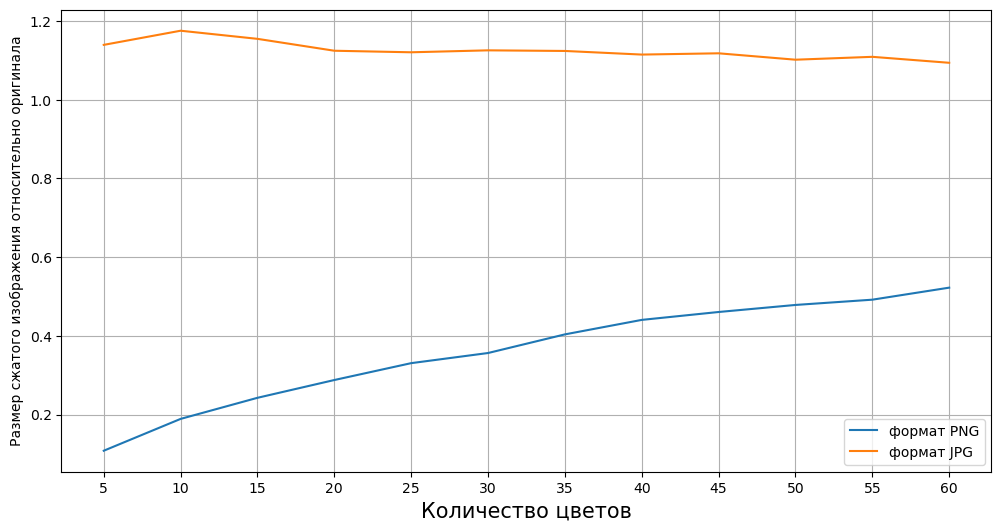

In [64]:
plt.style.use('default')
plt.subplots(figsize=(12, 6))

plt.plot(np.array(sizes_png) / size_orig_png, label='формат PNG');
plt.plot(np.array(sizes_jpg) / size_orig_jpg, label='формат JPG');
plt.grid(True)
plt.xticks(ticks=range(len(sizes_png)), labels=colors)
plt.legend()
plt.xlabel('Количество цветов', fontsize=15);
plt.ylabel('Размер сжатого изображения относительно оригинала', fontsize=10);

plt.savefig('KMeans_sizeof.png', bbox_inches='tight', pad_inches=.1, dpi=500)

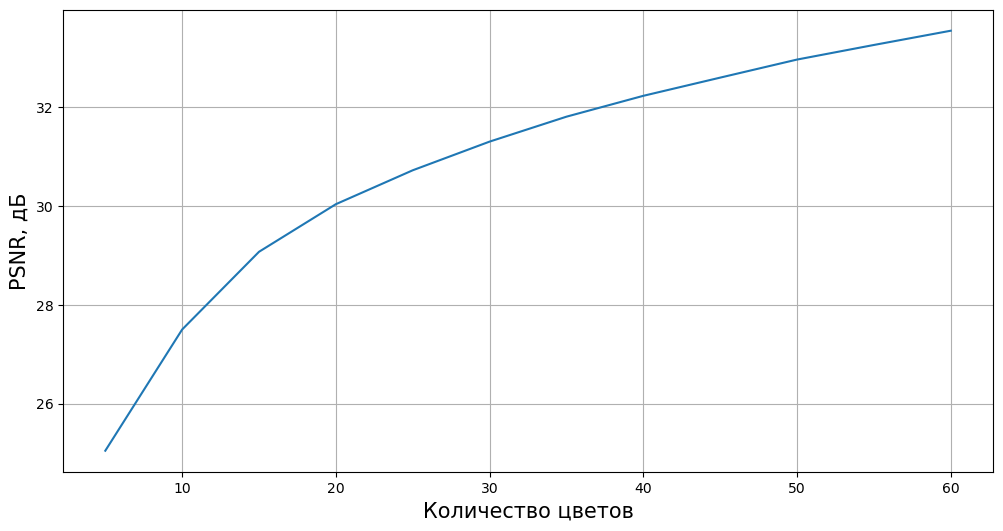

In [65]:
plt.style.use('default')
plt.subplots(figsize=(12, 6))

df['MEAN PSNR'].plot()
plt.xlabel('Количество цветов', fontsize=15);
plt.ylabel('PSNR, дБ', fontsize=15)
plt.grid(True)
#plt.xticks(ticks=range(len(colors)), labels=colors);

plt.savefig('KMeans_psnr.png', bbox_inches='tight', pad_inches=.1, dpi=500)

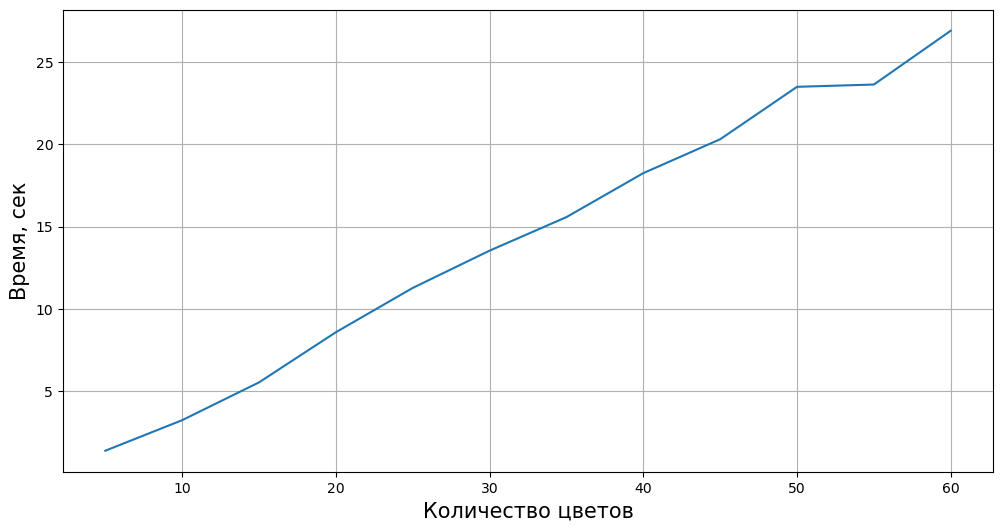

In [66]:
plt.style.use('default')
plt.subplots(figsize=(12, 6))

df['MEAN TIME'].plot()
plt.xlabel('Количество цветов', fontsize=15);
plt.ylabel('Время, сек', fontsize=15)
plt.grid(True)
#plt.xticks(ticks=range(len(colors)), labels=colors);

plt.savefig('KMeans_time.png', bbox_inches='tight', pad_inches=.1, dpi=500)

In [72]:
n_colors = 25
kmeans = KMeans(n_clusters=n_colors)
kmeans.fit(pixels)
y = kmeans.labels_

new_data = pixels.copy()
for i in range(n_colors):
        new_data[y == i] = np.mean(pixels[y == i], axis=0)
img_n_colors = new_data.reshape(img.shape)

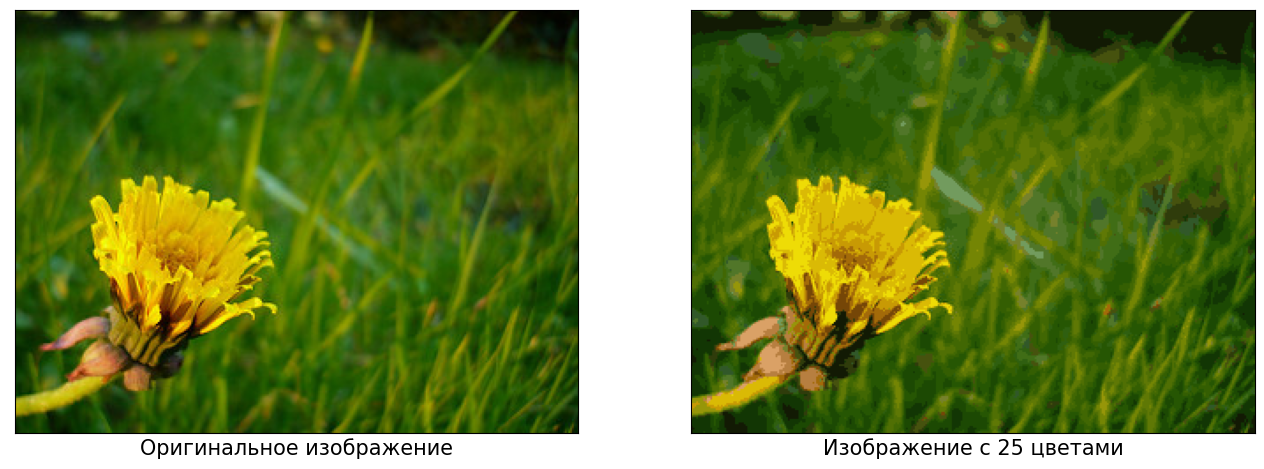

In [74]:
plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.xticks([]); plt.yticks([]);
plt.xlabel('Оригинальное изображение', fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(img_n_colors)
plt.xticks([]); plt.yticks([]);
plt.xlabel('Изображение с 25 цветами', fontsize=15)

plt.savefig('comp.jpg', bbox_inches='tight', pad_inches=.1, dpi=500)

# PCA

### Преобразование

In [9]:
num = np.random.randint(0, len(all_image_paths))
path = all_image_paths[num]

img = imread(path) / 255

#show(img, 'Real')

r = img[:, :, 0]
g = img[:, :, 1]
b = img[:, :, 2]

psnrs = []
path = 'data/pca/'
sizes_png = []
sizes_jpg = []
comps = range(1, 101)

for n_comp in comps:
    pca = PCA(n_components=n_comp)
    r_1 = pca.fit_transform(r)
    r1 = r_1 @ pca.components_# + pca.mean_
    g_1 = pca.fit_transform(g)
    g1 = g_1 @ pca.components_# + pca.mean_
    b_1 = pca.fit_transform(b)
    b1 = b_1 @ pca.components_# + pca.mean_
    new = np.zeros(img.shape)
    new[:, :, 0] = r1
    new[:, :, 1] = g1
    new[:, :, 2] = b1
    new = (new - new.min()) / (new.max() - new.min())
    name = f'{path}png/img{n_comp}.png'
    imsave(name, (new * 255).astype(np.uint8))
    sizes_png.append(os.stat(name).st_size)
    name = f'{path}jpg/img{n_comp}.jpg'
    imsave(name, (new * 255).astype(np.uint8))
    sizes_jpg.append(os.stat(name).st_size)
    
    psnrs.append(PSNR(img, new))

In [10]:
imsave(f'{path}png/img_orig.png', (img * 255).astype(np.uint8))
size_orig_png = os.stat(f'{path}png/img_orig.png').st_size

imsave(f'{path}jpg/img_orig.jpg', (img * 255).astype(np.uint8))
size_orig_jpg = os.stat(f'{path}jpg/img_orig.jpg').st_size

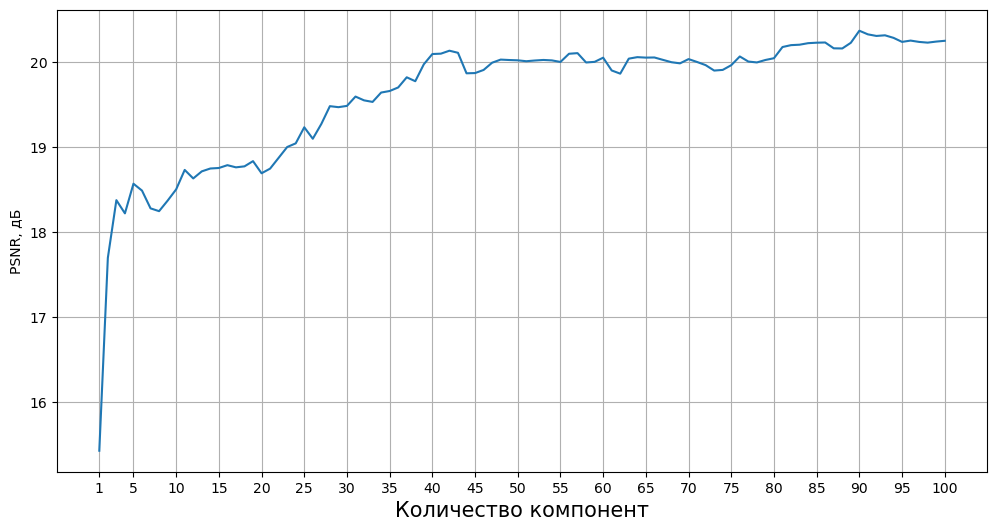

In [13]:
plt.style.use('default')
plt.subplots(figsize=(12, 6))

plt.plot(comps, psnrs);

plt.xticks([1] + list(range(5, 101, 5)));
plt.grid(True)
plt.xlabel('Количество компонент', fontsize=15);
plt.ylabel('PSNR, дБ', fontsize=10);

plt.savefig('PCA_psnr.png', bbox_inches='tight', pad_inches=.1, dpi=500)

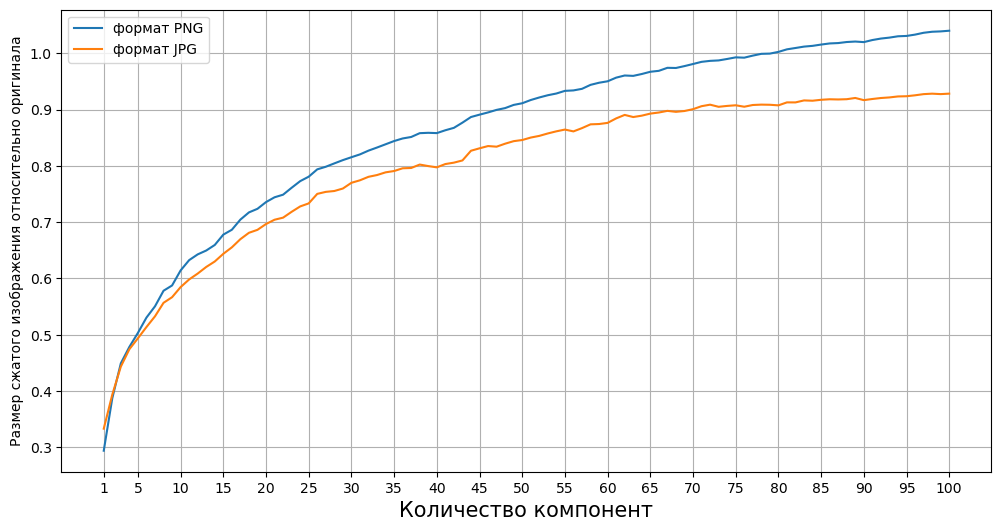

In [14]:
plt.style.use('default')
plt.subplots(figsize=(12, 6))

plt.plot(comps, np.array(sizes_png) / size_orig_png, label='формат PNG');
plt.plot(comps, np.array(sizes_jpg) / size_orig_jpg, label='формат JPG');
plt.xticks([1] + list(range(5, 101, 5)));

plt.grid(True)
plt.legend()
plt.xlabel('Количество компонент', fontsize=15);
plt.ylabel('Размер сжатого изображения относительно оригинала', fontsize=10);

plt.savefig('PCA_sizeof.png', bbox_inches='tight', pad_inches=.1, dpi=500)

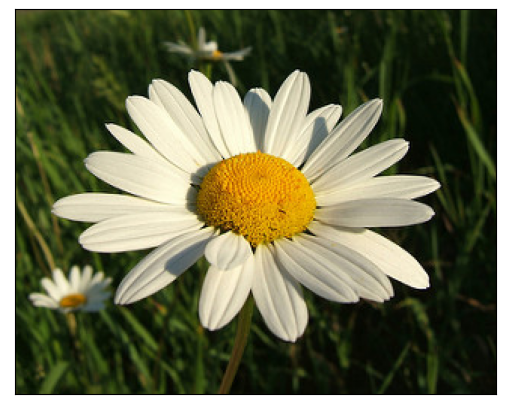

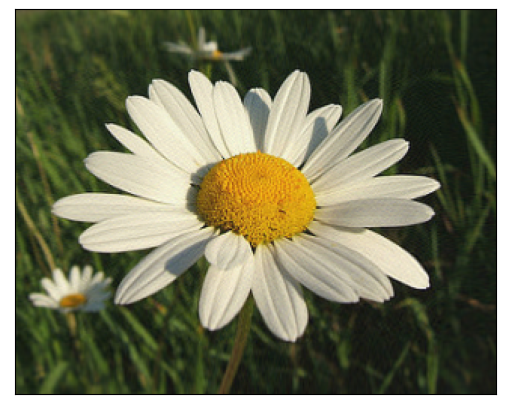

In [35]:
#num = np.random.randint(0, len(all_image_paths))
#path = all_image_paths[num]

#img = imread(path) / 255

r = img[:, :, 0]
g = img[:, :, 1]
b = img[:, :, 2]

n_comp = 100

pca = PCA(n_components=n_comp)
r_1 = pca.fit_transform(r)
r1 = r_1 @ pca.components_ + pca.mean_
g_1 = pca.fit_transform(g)
g1 = g_1 @ pca.components_ + pca.mean_
b_1 = pca.fit_transform(b)
b1 = b_1 @ pca.components_ + pca.mean_
new = np.zeros(img.shape)
new[:, :, 0] = r1
new[:, :, 1] = g1
new[:, :, 2] = b1
new = (new - new.min()) / (new.max() - new.min())

show(img)
show(new)

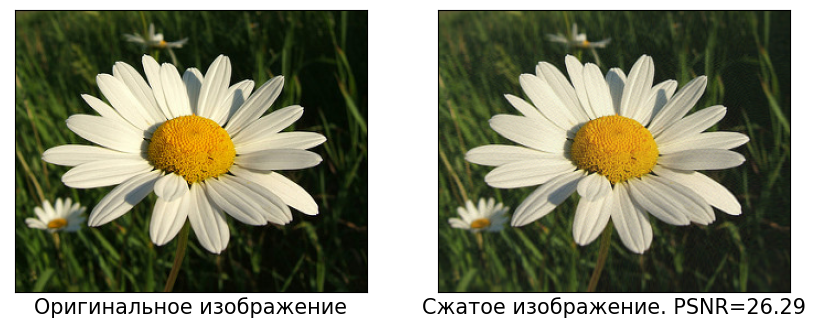

In [36]:
plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.xticks([]); plt.yticks([]);
plt.xlabel('Оригинальное изображение', fontsize=15)

plt.subplot(1, 2, 2)
plt.imshow(new)
plt.xticks([]); plt.yticks([]);
plt.xlabel(f'Сжатое изображение. PSNR={round(PSNR(img, new), 2)}', fontsize=15);

plt.savefig('PCA_comp.png', bbox_inches='tight', pad_inches=.1, dpi=500)

### NN

https://colab.research.google.com/drive/1HpMw-Nr7lr3dJJkwlzbf1x42v6I-c4Vz?usp=sharing

# Сравнение

In [ ]:
imgs = np.random.choice(all_image_paths, 30)
imgs = [imread(i) for i in imgs]

In [ ]:
for i in range(len(imgs)):
    imsave(f'Comparison/PNG/orig/img{i}.png', imgs[i])
    imsave(f'Comparison/JPG/orig/img{i}.jpg', imgs[i])

### PCA

In [ ]:
def process(i, img):
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]

    pca = PCA(n_components=45)
    r_1 = pca.fit_transform(r)
    r1 = r_1 @ pca.components_ + pca.mean_
    g_1 = pca.fit_transform(g)
    g1 = g_1 @ pca.components_ + pca.mean_
    b_1 = pca.fit_transform(b)
    b1 = b_1 @ pca.components_ + pca.mean_
    new = np.zeros(img.shape)
    new[:, :, 0] = r1
    new[:, :, 1] = g1
    new[:, :, 2] = b1
    new = (new - new.min()) / (new.max() - new.min())
    new = (new*255).astype(np.uint8)
    
    imsave(f'Comparison/PNG/pca/img{i}.png', new)
    imsave(f'Comparison/JPG/pca/img{i}.jpg', new)

In [ ]:
for i in range(len(imgs)):
    process(i, imgs[i])

### KMEANS

In [2]:
imgs = [imread(f'Comparison/PNG/orig/img{i}.png') / 255 for i in range(30)]

In [3]:
def process(num, img):
    n_colors = 45
    pixels = img.reshape([-1, 3])
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    y = kmeans.labels_

    new_data = pixels.copy()
    for i in range(n_colors):
            new_data[y == i] = np.mean(pixels[y == i], axis=0)
    img_n_colors = new_data.reshape(img.shape)
    
    new = (img_n_colors*255).astype(np.uint8)
    
    imsave(f'Comparison/PNG/kmeans/img{num}.png', new)
    imsave(f'Comparison/JPG/kmeans/img{num}.jpg', new)

In [4]:
for i in range(len(imgs)):
    process(i, imgs[i])

### NN

In [1]:
import tensorflow as tf
from skimage.io import imsave, imread
import matplotlib.pyplot as plt
import numpy as np

In [4]:
model = tf.keras.models.load_model('model_colab')

In [5]:
imgs = [imread(f'Comparison/PNG/orig/img{i}.png') / 255 for i in range(30)]

In [6]:
def nearest(x, n=16):
    return x + n - x%n - n*(x%n == 0)

def pr(img, n=16):
    if img.max() > 1:
        img = img / 255.
    new = np.zeros([nearest(img.shape[0], n), nearest(img.shape[1], n), 3])
    new[:img.shape[0], :img.shape[1]] = img
    return new

def split_(img, n=16, cube=False):
    img = pr(img, n=n)
    if not cube:
        return img.reshape([-1, n, n, 3])
    h = []
    for i in range(img.shape[0] // n):
        for j in range(img.shape[1] // n):
            h.append(img[i*n:i*n+n, j*n:j*n+n])
    return np.array(h)

def join_(img, h, w, n=16, cube=False):
    new = np.zeros([h, w, 3])
    if not cube:
        return img.reshape([h, w, 3])
    c = 0
    for i in range(h//n):
        for j in range(w//n):
            new[i*n:i*n+n, j*n:j*n+n] = img[c]
            c += 1
    return new

In [25]:
def compress(num, img):
    img = pr(img)
    shapes = np.array([img.shape[0], img.shape[1]])
    x = split_(img, cube=1)
    x = model.encoder(x).numpy()
    x = (x * 255).astype(np.uint8)
    
    np.save(f'Comparison/PNG/neural/Compressed/shapes{num}.npy', shapes)
    np.save(f'Comparison/JPG/neural/Compressed/shapes{num}.npy', shapes)
    
    imsave(f'Comparison/PNG/neural/Compressed/img{num}.png', x)
    imsave(f'Comparison/JPG/neural/Compressed/img{num}.jpg', x)

In [26]:
for i in range(len(imgs)):
    compress(i, imgs[i])

In [27]:
def decompress(num):
    shapes = np.load(f'Comparison/PNG/neural/Compressed/shapes{num}.npy')
    
    x = imread(f'Comparison/JPG/neural/Compressed/img{num}.jpg') / 255
    y = model.decoder(x).numpy()
    y = join_(y, h=shapes[0], w=shapes[1], cube=1)
    y = (y * 255).astype(np.uint8)
    imsave(f'Comparison/JPG/neural/Decompressed/img{num}.jpg', y)
    
    x = imread(f'Comparison/PNG/neural/Compressed/img{num}.png') / 255
    y = model.decoder(x).numpy()
    y = join_(y, h=shapes[0], w=shapes[1], cube=1)
    y = (y * 255).astype(np.uint8)
    imsave(f'Comparison/PNG/neural/Decompressed/img{num}.png', y)

In [28]:
for i in range(30):
    decompress(i)

### DataFrame

In [ ]:
def count_mem(p):
    p = pathlib.Path(p)
    x = list(p.glob('*'))
    mem = 0
    for i in x:
        mem += os.stat(i).st_size
    return mem

orig_sizes_jpg = count_mem('Comparison/JPG/orig')
orig_sizes_png = count_mem('Comparison/PNG/orig')

In [ ]:
orig_imgs = [imread(f'Comparison/JPG/orig/img{i}.jpg') / 255 for i in range(30)]

In [ ]:
kmeans = []
for i in range(30):
    img = imread(f'Comparison/JPG/kmeans/img{i}.jpg') / 255
    kmeans.append(PSNR(img, orig_imgs[i]))

In [ ]:
pca = []
for i in range(30):
    img = imread(f'Comparison/JPG/pca/img{i}.jpg') / 255
    pca.append(PSNR(img, orig_imgs[i]))

In [ ]:
neuro = []
for i in range(30):
    img = imread(f'Comparison/JPG/neural/Decompressed/img{i}.jpg') / 255
    neuro.append(PSNR(img, pr(orig_imgs[i])))

In [ ]:
kmeansjpg = count_mem('Comparison/JPG/kmeans') / orig_sizes_jpg
kmeanspng = count_mem('Comparison/PNG/kmeans') / orig_sizes_png

In [ ]:
pcajpg = count_mem('Comparison/JPG/pca') / orig_sizes_jpg
pcapng = count_mem('Comparison/PNG/pca') / orig_sizes_png

In [ ]:
neurojpg = count_mem('Comparison/JPG/neural/Compressed') / orig_sizes_jpg
neuropng = count_mem('Comparison/PNG/neural/Compressed') / orig_sizes_png

In [ ]:
df = pd.DataFrame(index=['KMeans', 'PCA', 'NN'])
df['MEAN_PSNR'] = [np.mean(kmeans), np.mean(pca), np.mean(neuro)]
df['MEMORY_JPG'] = [kmeansjpg, pcajpg, neurojpg]
df['MEMORY_PNG'] = [kmeanspng, pcapng, neuropng]
round(df, 3)#.to_excel('comp.xlsx')